In [2]:
using Distributed
addprocs(3)

3-element Array{Int64,1}:
 2
 3
 4

In [3]:
using CSV
using DataFrames
using Distributions
using HTTP
import ForneyLab.dot2svg
@everywhere using Mamba
# using Mamba
using Plots

[ Info: Loading DataFrames support into Gadfly.jl
[ Info: Loading DataFrames support into Gadfly.jl
┌ Info: Loading DataFrames support into Gadfly.jl
└ @ Gadfly /Users/apple/.julia/packages/Gadfly/09PWZ/src/mapping.jl:228
[ Info: Loading DataFrames support into Gadfly.jl


# 1 ベイズ推論の考え方
## 1.4 例題 : メッセージ数に変化はあるのか？
メッセージ受信数が時間が経つにつれて変化するかどうかを調べる

In [4]:
r = HTTP.request("GET", "https://git.io/vXTVC");
count_data = CSV.read(IOBuffer(r.body), header=["messages"])
count_data.messages = convert.(Int64, count_data.messages)
disallowmissing!(count_data)

,messages
,Int64
1,13
2,24
3,8
4,24
5,7
6,35
7,14
8,11
9,15


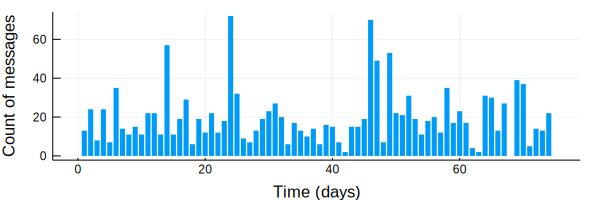

In [5]:
bar(count_data.messages, label = "", size = [600, 200],
    linecolor = :transparent,
    xlabel = "Time (days)", ylabel = "Count of messages")

$i$日目のメッセージを$C_i$とするとき、
\begin{align}
C_i \sim \text{Poisson}(\lambda)
\end{align}
ここで、どこかで$\lambda$が大きくなっているか調べるために、
\begin{align}
\lambda = \left\{ \begin{array}{ll}
\lambda_1 & \text{if}\ t < \tau,\\
\lambda_2 & \text{if}\ t \ge \tau. 
\end{array} \right.
\end{align}
となっていると仮定する。
事前分布は、
\begin{align}
\lambda_1 & \sim \text{Exp}(\alpha) \\
\lambda_2 & \sim \text{Exp}(\alpha) \\
\tau & \sim \text{DiscreteUniform}(1,74)
\end{align}
とする。$\alpha$は係数データの平均の逆数とする。

In [6]:
alpha = 1 / mean(count_data.messages)

0.05065023956194388

In [8]:
model1 = Model(
    observation = Stochastic(1,
        (lambda, N) ->
        UnivariateDistribution[Poisson(lambda[i]) for i in 1:N],
        false
    ),
    
    lambda = Logical(1,
        (lambda1, lambda2, tau, N) ->
        begin
            out = fill(lambda1.value, N)
            out[Int64(tau.value):end, :] .= lambda2.value
            out
        end,
    false
    ),
    
    lambda1 = Stochastic(alpha -> Truncated(Exponential(alpha), 1, Inf)),
    lambda2 = Stochastic(alpha -> Truncated(Exponential(alpha), 1, Inf)),
    
    tau = Stochastic(N -> DiscreteUniform(1, N)),
)

Object of type "Model"
-------------------------------------------------------------------------------
lambda:
An unmonitored node of type "0-element ArrayLogical{1}"
Float64[]
-------------------------------------------------------------------------------
lambda1:
A monitored node of type "ScalarStochastic"
NaN
-------------------------------------------------------------------------------
observation:
An unmonitored node of type "0-element ArrayStochastic{1}"
Float64[]
-------------------------------------------------------------------------------
tau:
A monitored node of type "ScalarStochastic"
NaN
-------------------------------------------------------------------------------
lambda2:
A monitored node of type "ScalarStochastic"
NaN


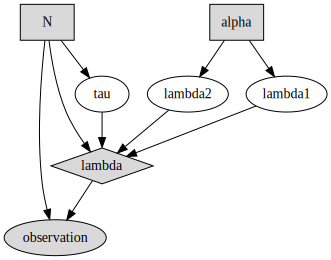

In [9]:
display("image/svg+xml", dot2svg(graph2dot(model1)))

In [10]:
data1 = Dict{Symbol, Any}(
    :observation => count_data.messages,
    :alpha => alpha,
    :N => length(count_data.messages),
)

Dict{Symbol,Any} with 3 entries:
  :alpha       => 0.0506502
  :N           => 74
  :observation => [13, 24, 8, 24, 7, 35, 14, 11, 15, 11  …  30, 13, 27, 0, 39, …

In [11]:
inits1 = [
    Dict{Symbol, Any}(
        :observation => zeros(length(count_data.messages)),
        :lambda1 => fill(1 / alpha, length(count_data.messages)),
        :lambda1 => 1 / alpha,
        :lambda2 => 1 / alpha,
        :tau => 45,
    ) for i in 1:3
]

3-element Array{Dict{Symbol,Any},1}:
 Dict(:lambda1=>19.7432,:observation=>[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],:tau=>45,:lambda2=>19.7432)
 Dict(:lambda1=>19.7432,:observation=>[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],:tau=>45,:lambda2=>19.7432)
 Dict(:lambda1=>19.7432,:observation=>[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],:tau=>45,:lambda2=>19.7432)

In [27]:
scheme1 = [DGS(:tau), AMWG([:lambda1, :lambda2], 1.0)]

2-element Array{Sampler,1}:
 An object of type "Sampler{Mamba.DSTune{Function}}"
Sampling Block Nodes:
Symbol[:tau]

CodeInfo(
1 ─ %1 = π (##238#241(Box(Symbol[:tau])), Const(##238#241(Box(Symbol[:tau])), false))
│   %2 = (%1)(model, block)::Const(nothing, false)
└──      return %2
) => Nothing
                                                                                                                                                                                                                                                            
 An object of type "Sampler{Mamba.AMWGTune}"
Sampling Block Nodes:
Symbol[:lambda1, :lambda2]

CodeInfo(
1 ─ %1 = π (##198#200{Symbol,Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Float64}(:all, Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}(), 1.0), Const(##198#200{Symbol,Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Float64}(:all, Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}(), 1.0), 

In [ ]:
setsamplers!(model1, scheme1)
sim1 = mcmc(model1, data1, inits1, 40000, burnin = 10000, thin = 10, chains = 3)

MCMC Simulation of 40000 Iterations x 3 Chains...

      From worker 4:	Chain 1:   0% [0:02:50 of 0:02:50 remaining]
      From worker 2:	Chain 2:   0% [0:02:59 of 0:02:59 remaining]
      From worker 3:	Chain 3:   0% [0:03:25 of 0:03:25 remaining]
      From worker 4:	Chain 1:  10% [0:01:21 of 0:01:29 remaining]
      From worker 2:	Chain 2:  10% [0:01:22 of 0:01:31 remaining]
      From worker 3:	Chain 3:  10% [0:01:25 of 0:01:34 remaining]
      From worker 4:	Chain 1:  20% [0:01:13 of 0:01:31 remaining]
      From worker 2:	Chain 2:  20% [0:01:13 of 0:01:32 remaining]
      From worker 3:	Chain 3:  20% [0:01:15 of 0:01:34 remaining]
      From worker 4:	Chain 1:  30% [0:01:06 of 0:01:34 remaining]
      From worker 2:	Chain 2:  30% [0:01:06 of 0:01:35 remaining]
      From worker 3:	Chain 3:  30% [0:01:07 of 0:01:36 remaining]
      From worker 4:	Chain 1:  40% [0:00:57 of 0:01:35 remaining]
      From worker 2:	Chain 2:  40% [0:00:57 of 0:01:36 remaining]
      From worker 3:	Chai

In [ ]:
describe(sim1)

In [ ]:
p1 = Mamba.plot(sim1, legend = true)
Mamba.draw(p1[:, 1:3], nrow = 3, ncol = 2)